# Property Selling Price Regression II with Ridge, LASSO, and Elastic Net Regression, February 2018

# Introduction
* While nearing completion of my binary classification project, I looked back on my multiple regression project. I wanted to try out regression methods more advanced than simple multiple regression, and apply concepts that I know now that I was not familiar with last fall. In particular, I was eager to tackle a regression problem with regularization, penalization of regression coefficients.
* I hacked this project together over the course of two days, experimenting for the first time with these 3 new methods: Ridge, LASSO, and Elastic Net. Ridge better handles multicollinearity among independent variables, and LASSO performs variable selection. Elastic Net recovers both ridge (l2) and LASSO (l1) regularization.
* Data and data field descriptions for this Kaggle-popular dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import math
import warnings
import scipy.stats as stats

warnings.filterwarnings('ignore')

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.base import TransformerMixin
from sklearn.metrics import mean_squared_error


% matplotlib inline

In [2]:
df_train = pd.read_csv('/Users/jordanbauer/Data Mining Learning/Personal Projects/Multiple Regression/real_estate_train.csv')
df_original = pd.read_csv('/Users/jordanbauer/Data Mining Learning/Personal Projects/Multiple Regression/real_estate_train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.set_index('Id', inplace=True)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Data Preparation
The NaN values for some of our values are not actually missing: with our fence variable, for instance, NaN means there is no fence. We need to refactor these null values before we proceed.

In [6]:
def refactor_nans(df, variables):
    for var in variables:
        df[var].fillna(value='N', inplace=True)

refactor_nans(df_train, ['PoolQC', 'Alley', 'Fence', 'MiscFeature', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'FireplaceQu', 'BsmtFinType2', 'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual'])

In [7]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,N,Reg,Lvl,AllPub,Inside,...,0,N,N,N,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,N,Reg,Lvl,AllPub,FR2,...,0,N,N,N,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,N,IR1,Lvl,AllPub,Inside,...,0,N,N,N,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,N,IR1,Lvl,AllPub,Corner,...,0,N,N,N,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,N,IR1,Lvl,AllPub,FR2,...,0,N,N,N,0,12,2008,WD,Normal,250000


In [8]:
def show_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    df = pd.concat([total, percent], axis=1, keys=['Count', '% Missing Data'])
    df = df[df['Count'] > 0]
    return df

missing_1 = show_missing(df_train)
missing_1

,Count,% Missing Data
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685


In [9]:
refactor_nans(df_train, ['MasVnrType', 'Electrical'])
df_train['MasVnrArea'].fillna(value=0, inplace=True)
df_train['LotFrontage'].fillna(value=0, inplace=True)
df_train['GarageYrBlt'].fillna(value=99999, inplace=True)

In [10]:
missing_2 = show_missing(df_train)
missing_2

,Count,% Missing Data


Our variables describing years span over 100 years. We don't need a dummy variable for each year, so we'll bin these variables by decade.

In [11]:
def cat_refactor(df, variables):
    count = 0
    refactors = {}
    for var in variables:
        for value in df[var].unique():
            df.loc[df[var] == value, var] = str(count)
            refactors[value] = count
            count += 1

cat_refactor(df_train, ['MSSubClass', 'MoSold'])

In [12]:
for var in ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']:
    df_train.loc[df_train[var] <= 1889, var] = 0
    df_train.loc[(df_train[var] >= 1890) & (df_train[var] < 1900), var] = 1
    df_train.loc[(df_train[var] >= 1900) & (df_train[var] < 1910), var] = 2
    df_train.loc[(df_train[var] >= 1910) & (df_train[var] < 1920), var] = 3
    df_train.loc[(df_train[var] >= 1920) & (df_train[var] < 1930), var] = 4
    df_train.loc[(df_train[var] >= 1930) & (df_train[var] < 1940), var] = 5
    df_train.loc[(df_train[var] >= 1940) & (df_train[var] < 1950), var] = 6
    df_train.loc[(df_train[var] >= 1950) & (df_train[var] < 1960), var] = 7
    df_train.loc[(df_train[var] >= 1960) & (df_train[var] < 1970), var] = 8
    df_train.loc[(df_train[var] >= 1970) & (df_train[var] < 1980), var] = 9
    df_train.loc[(df_train[var] >= 1980) & (df_train[var] < 1990), var] = 10
    df_train.loc[(df_train[var] >= 1990) & (df_train[var] < 2000), var] = 11
    df_train.loc[(df_train[var] >= 2000) & (df_train[var] < 2010), var] = 12
    df_train.loc[(df_train[var] >= 2010), var] = 13
    df_train[var] = df_train[var].astype('object')

In [13]:
categorical_feats = df_train.select_dtypes(include=["object"]).columns.tolist()
continuous_feats = df_train.select_dtypes(exclude=["object"]).columns.tolist()

Encoding our other categorical values into numerals.

In [14]:
for var in categorical_feats:
    df_train[var] = df_train[var].astype('category')
    df_train[var] = df_train[var].cat.codes
    df_train[var] = df_train[var].astype('object')

Our "testing" file does not truly come with true target values, thus it isn't really a testing set to measure our performance. We'll have to randomly training and testing sets. While we're at it, we can create dummy variables for down the road.

In [15]:
df_train_dummies = pd.get_dummies(df_train, columns=categorical_feats, drop_first=True)
X, X_holdout, y, y_holdout = train_test_split(df_train_dummies.drop('SalePrice', axis=1), df_train_dummies['SalePrice'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

# Date Preparation and Preprocessing
Outliers can heavily corrupt the predictive power of our models. We'll eliminate values that don't clearly don't play along with the overall trend. Also, we have a great deal of zero values skewing our spreads that need our attention; a basement square footage variable is great, except for the properties that don't have basements. We can circumvent these by creating binary variables to describe the most extreme cases or refactor zeros to be the mean of the distribution.

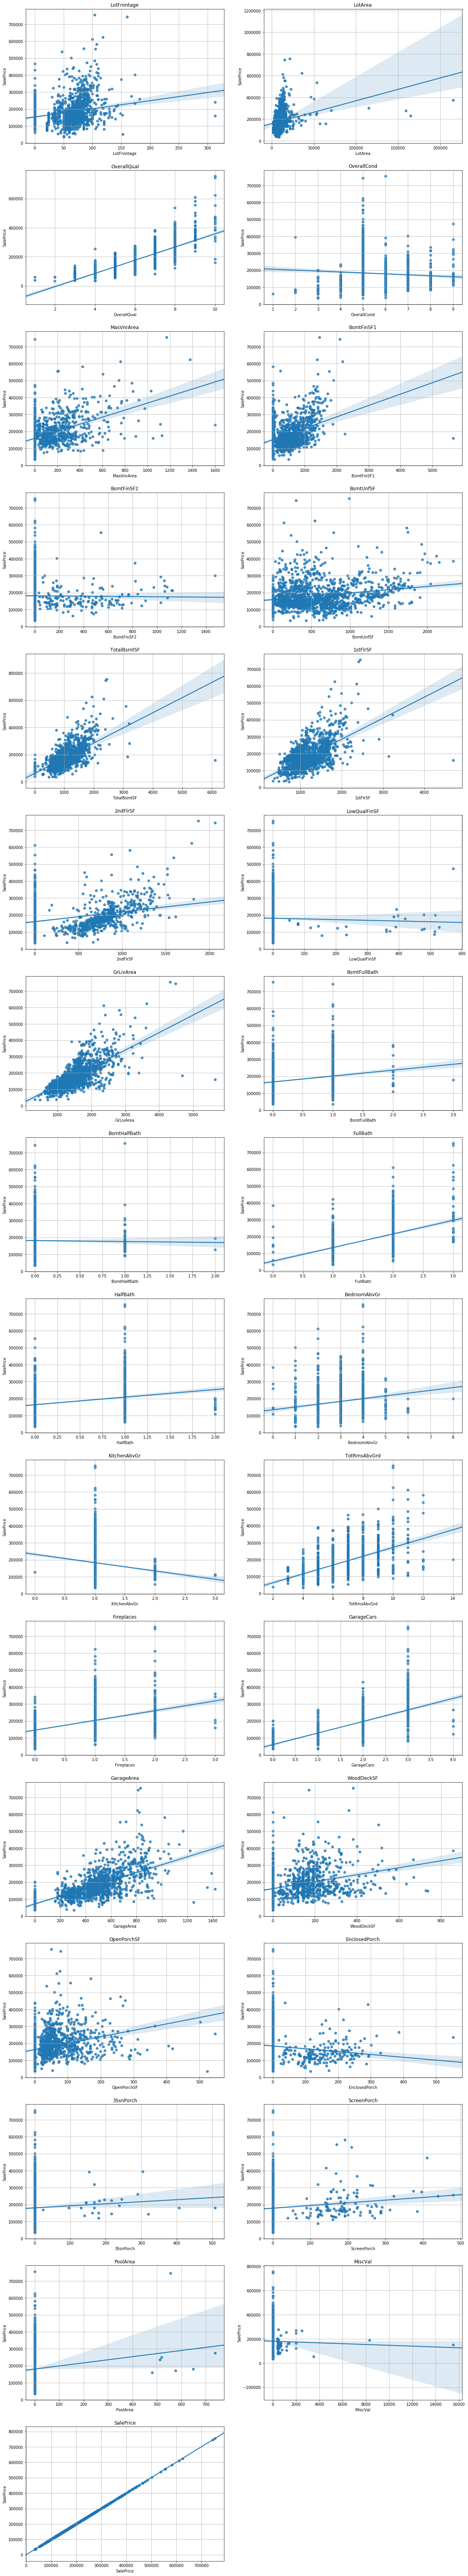

In [16]:
plt.figure(figsize=(20, 7.5*float(round(len(continuous_feats)/2))))
for i, var in enumerate(continuous_feats):
    plt.subplot(round(len(continuous_feats)/2), 2, i+1)
    plt.title(var)
    sns.regplot(data=df_train, x=var, y='SalePrice')
    plt.ylabel('SalePrice')
    plt.xlabel(var)
    plt.grid()

Now without zeros.

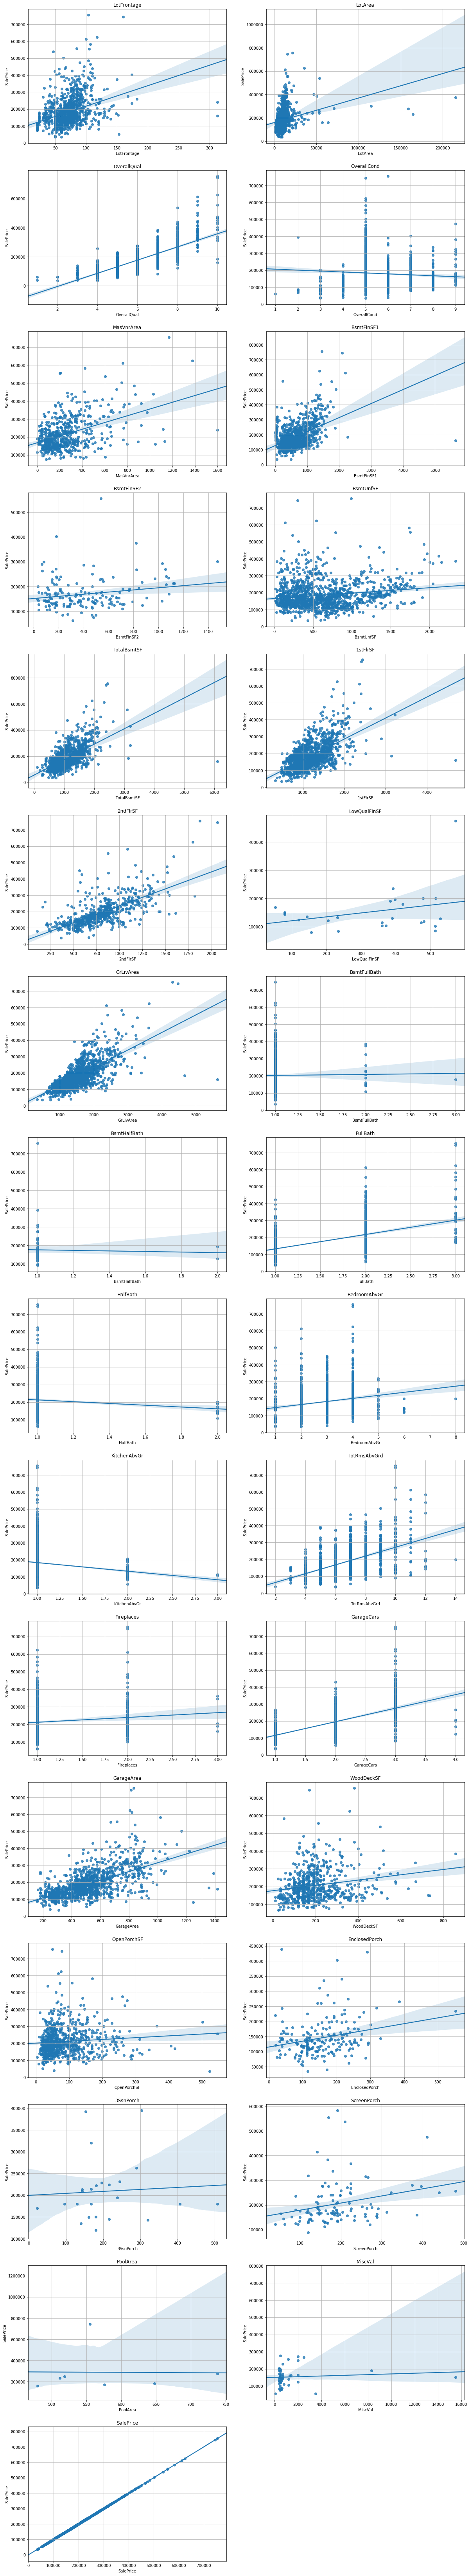

In [17]:
plt.figure(figsize=(20, 7.5*16))
for i, var in enumerate(continuous_feats):
    plt.subplot(16, 2, i+1)
    plt.title(var)
    sns.regplot(data=df_train[df_train[var] != 0], x=var, y='SalePrice')
    plt.ylabel('SalePrice')
    plt.xlabel(var)
    plt.grid()

We can remove some obvious outliers that are swaying our regression lines. We'll also rework some of our variables into binary categorical variables.

In [18]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4500) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 5000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.drop(df_train[(df_train['LotArea'] > 100000) & (df_train['SalePrice'] < 500000)].index)
df_train = df_train.drop(df_train[(df_train['BsmtFinSF1'] > 5000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.drop(df_train[(df_train['1stFlrSF'] > 4000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.drop(df_train[(df_train['LotFrontage'] > 300) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['MiscVal'] > 8000) & (df_train['SalePrice'] > 100000)].index)

In [19]:
df_train['HasPool'] = df_train['PoolArea'].where(df_train['PoolArea'] == 0, 1)
df_train['HasPool'] = df_train['HasPool'].astype('object')
df_train.drop(['PoolQC', 'PoolArea'], axis=1, inplace=True)
df_train['HasMiscFeature'] = df_train['MiscFeature'].where(df_train['MiscFeature'] == 1, 1)
df_train['HasMiscFeature'] = df_train['HasMiscFeature'].where(df_train['MiscFeature'] != 1, 0)
df_train['HasMiscFeature'] = df_train['HasMiscFeature'].astype('object')
df_train.drop(['MiscFeature', 'MiscVal'], axis=1, inplace=True)
df_train['Has3SsnPorch'] = df_train['3SsnPorch'].where(df_train['3SsnPorch'] == 0, 1)
df_train['Has3SsnPorch'] = df_train['Has3SsnPorch'].astype('object')
df_train.drop('3SsnPorch', axis=1, inplace=True)
df_train['HasBsmtFullBath'] = df_train['BsmtFullBath'].where(df_train['BsmtFullBath'] == 0, 1)
df_train['HasBsmtFullBath'] = df_train['HasBsmtFullBath'].astype('object')
df_train.drop('BsmtFullBath', axis=1, inplace=True)

In [20]:
categorical_feats = df_train.select_dtypes(include=["object"]).columns.tolist()
continuous_feats = df_train.select_dtypes(exclude=["object"]).columns.tolist()

In [21]:
df_train_dummies = pd.get_dummies(df_train, columns=categorical_feats, drop_first=True)
X, X_holdout, y, y_holdout = train_test_split(df_train_dummies.drop('SalePrice', axis=1), df_train_dummies['SalePrice'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

We still have some more continuous variables that need attention, since scatter plots don't always tell the whole story of the distribution. Skewness/non-normal distributions in our variables will hurt our regression, so we'll need to identify those variables displaying skewness and apply transformations where necessary.

In [22]:
def skewness(df, variables):
    temp_dict = {}
    for var in variables:
        temp_dict[var] = df[var].skew()
    return pd.Series(temp_dict).sort_values()

train_skew = skewness(train, continuous_feats)

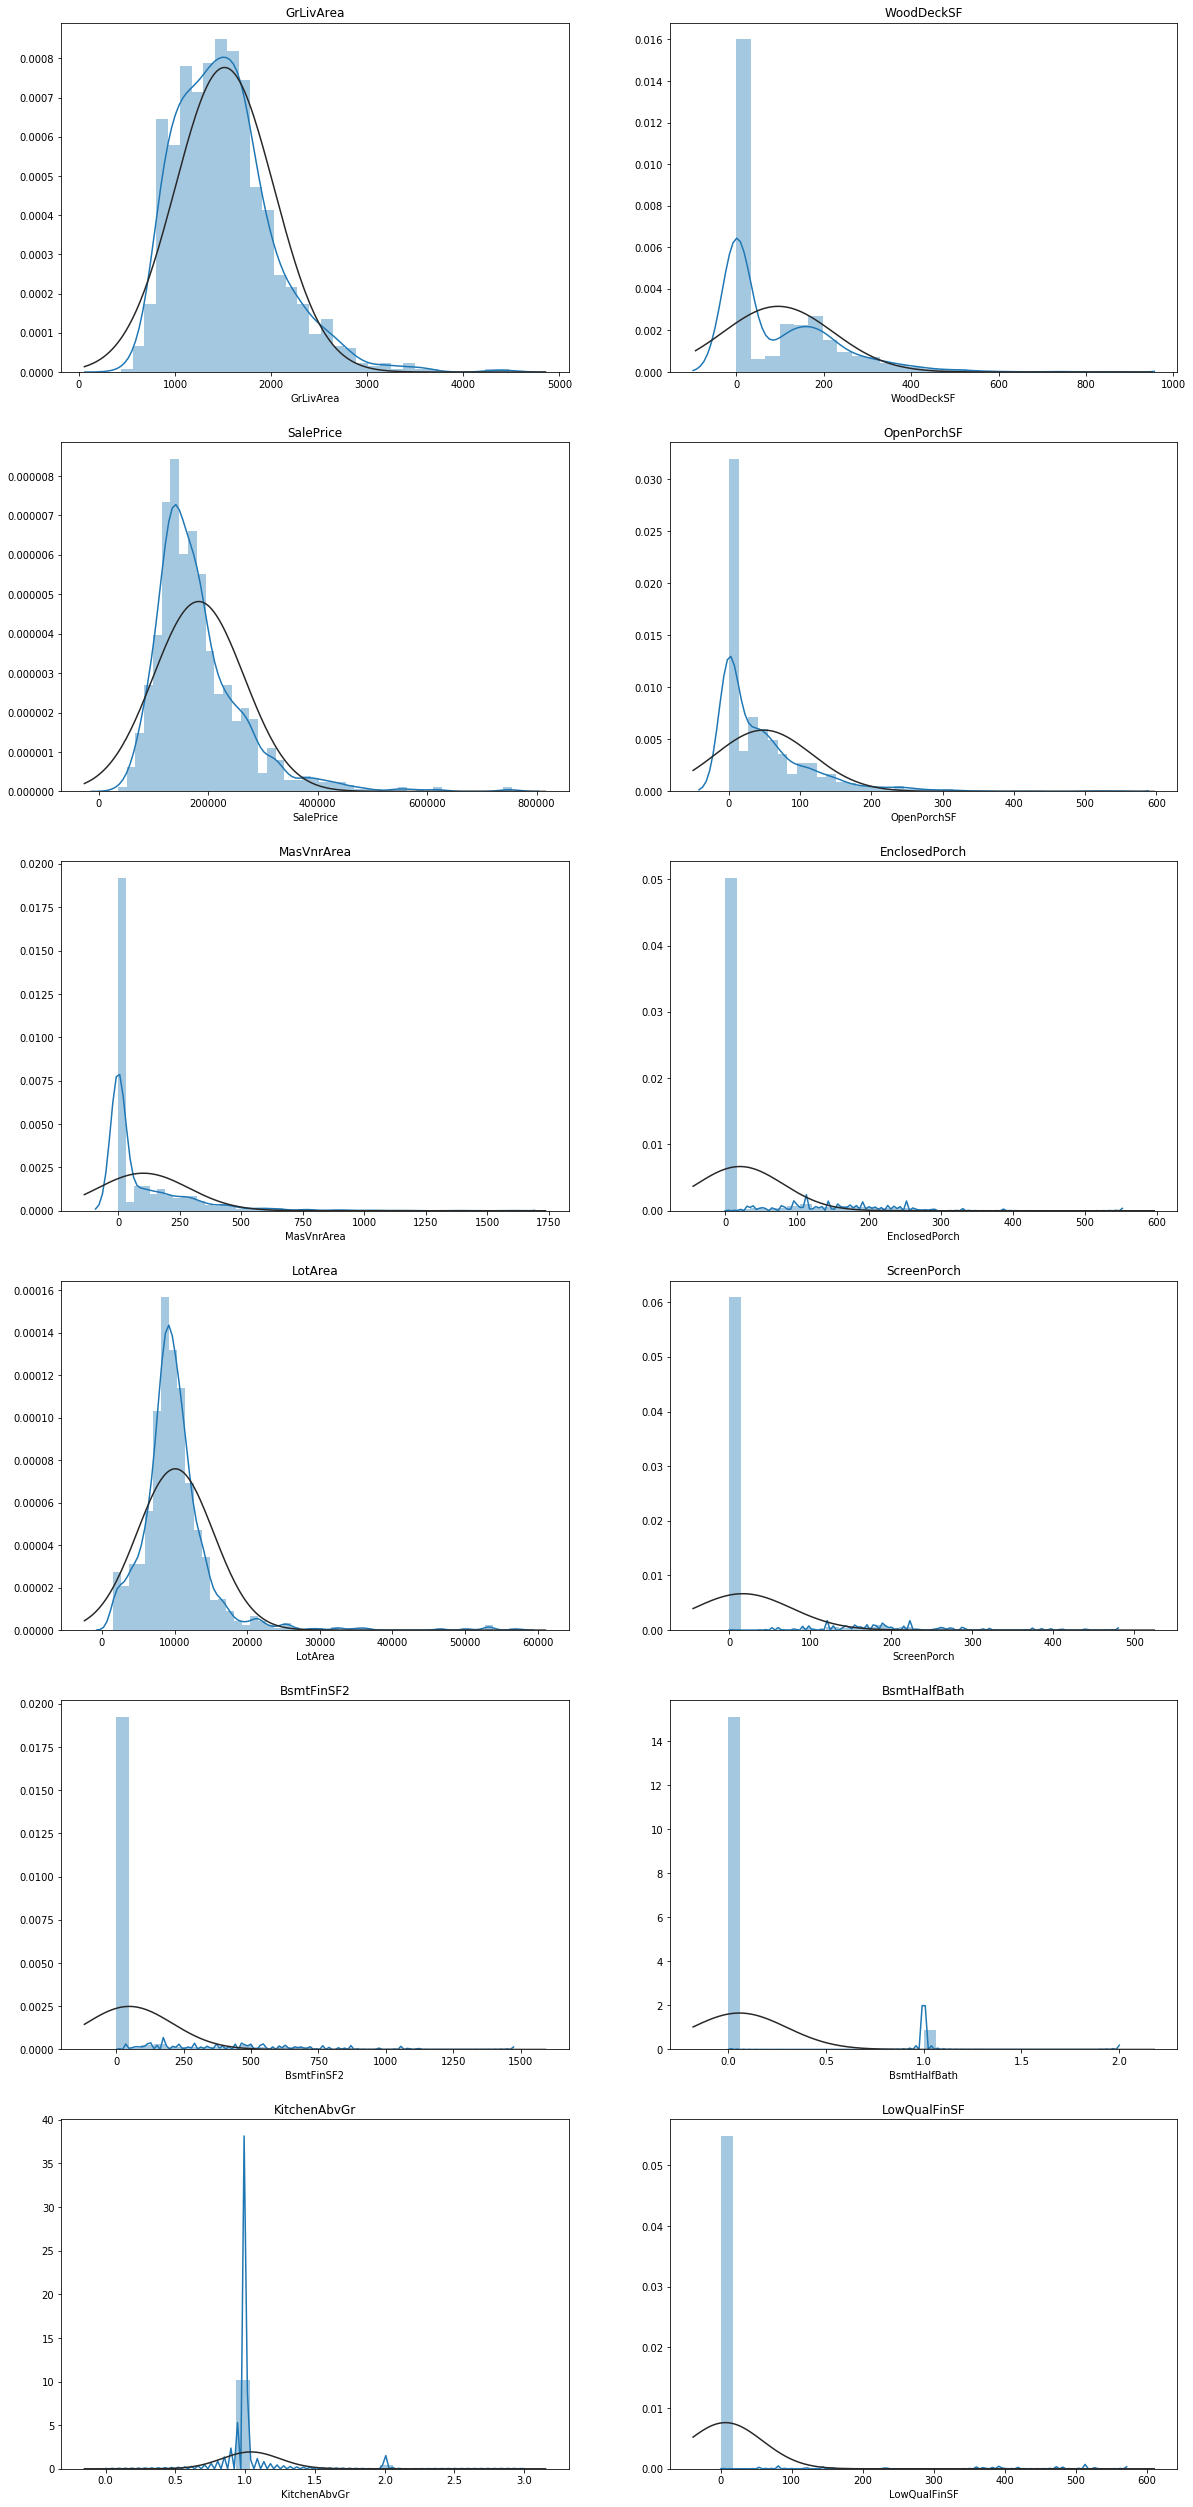

In [23]:
plt.figure(figsize=(20, 7.5*round(len(train_skew[train_skew > 1.0])/2)))
for i, var in enumerate(train_skew[train_skew > 1.0].sort_values().index):
    plt.subplot(math.ceil(len(train_skew[train_skew > 1.0])/2), 2, i+1)
    plt.title(var)
    sns.distplot(train[var], fit=stats.norm)

Our target variable "SalePrice" is also prominently lopsided.

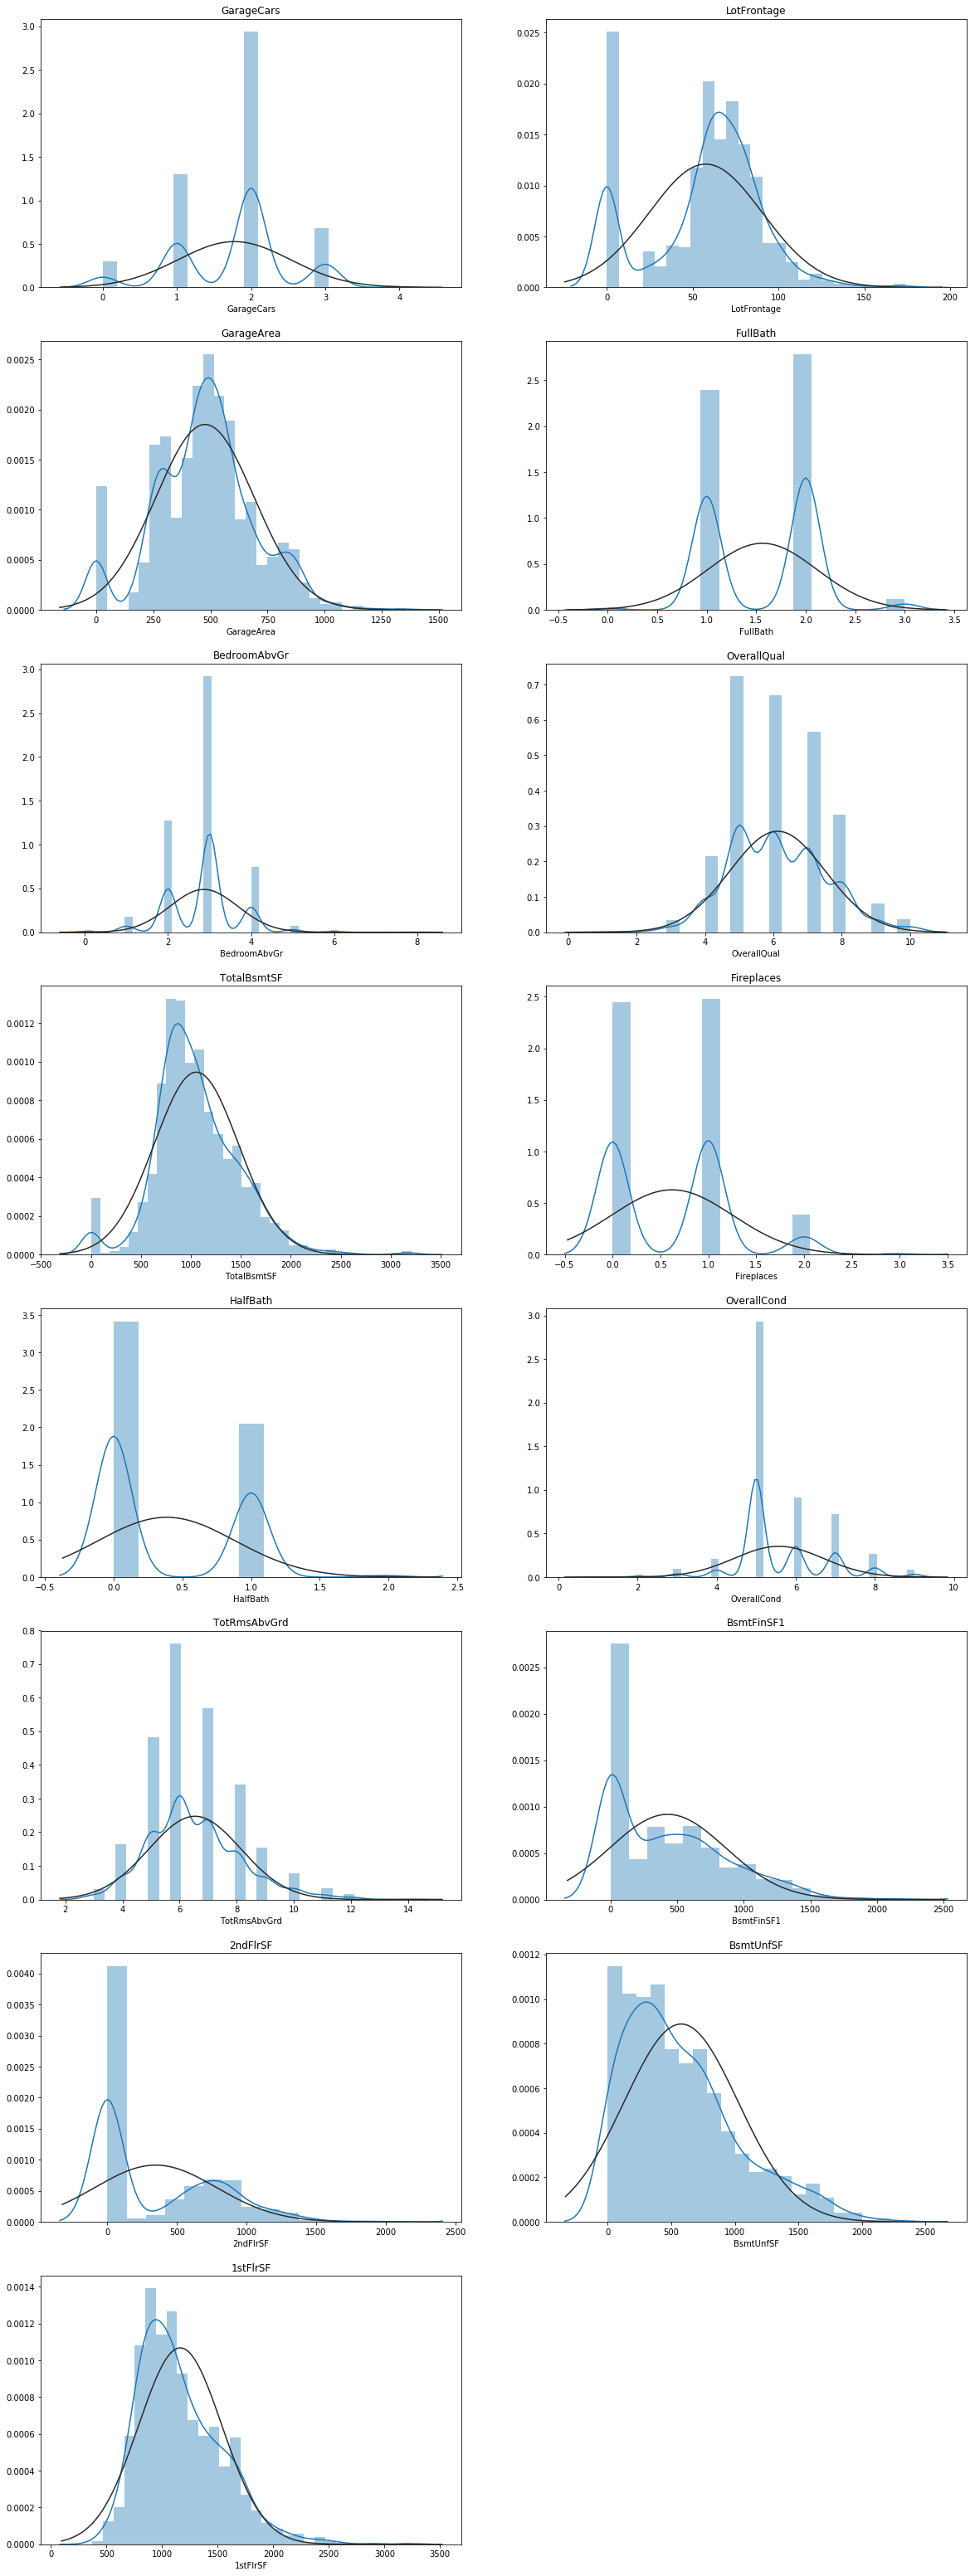

In [24]:
plt.figure(figsize=(20, 7*math.ceil(len(train_skew[train_skew < 1.0])/2)))
for i, var in enumerate(train_skew[train_skew < 1.0].index):
    plt.subplot(math.ceil(len(train_skew[train_skew < 1.0])/2), 2, i+1)
    plt.title(var)
    sns.distplot(train[var], fit=stats.norm)

We have some more variables that would be better suited/accompanied by binary variables, such as having a basement or a second floor.

In [25]:
refactor_0s = ['WoodDeckSF', 'OpenPorchSF', 'MasVnrArea', 'LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageArea', 'LotFrontage', '2ndFlrSF', 'SalePrice']

In [26]:
df_train['HasLotFrontage'] = df_train['LotFrontage'].where(df_train['LotFrontage'] == 0, 1).astype('category')
df_train['Has2ndFlr'] = df_train['2ndFlrSF'].where(df_train['2ndFlrSF'] == 0, 1).astype('category')
df_train['HasGarage'] = df_train['GarageArea'].where(df_train['GarageArea'] == 0, 1).astype('category')
df_train['HasBsmt'] = df_train['TotalBsmtSF'].where(df_train['TotalBsmtSF'] == 0, 1).astype('category')
df_train['HasOpenPorch'] = df_train['OpenPorchSF'].where(df_train['OpenPorchSF'] == 0, 1).astype('category')
df_train['HasWoodDeck'] = df_train['WoodDeckSF'].where(df_train['WoodDeckSF'] == 0, 1).astype('category')
df_train['HasEnclosedPorch'] = df_train['EnclosedPorch'].where(df_train['EnclosedPorch'] == 0, 1).astype('category')
df_train.drop('EnclosedPorch', axis=1, inplace=True)
df_train['HasScreenPorch'] = df_train['ScreenPorch'].where(df_train['ScreenPorch'] == 0, 1).astype('category')
df_train.drop('ScreenPorch', axis=1, inplace=True)
df_train['HasLowQualFinSF'] = df_train['LowQualFinSF'].where(df_train['LowQualFinSF'] == 0, 1).astype('category')
df_train.drop('LowQualFinSF', axis=1, inplace=True)
df_train['MultKitchenAbvGr'] = df_train['KitchenAbvGr'].where(df_train['KitchenAbvGr'] < 2, 1).astype('category')
df_train.drop('KitchenAbvGr', axis=1, inplace=True)
df_train['HasBsmtHalfBath'] = df_train['BsmtHalfBath'].where(df_train['BsmtHalfBath'] == 0, 1).astype('category')
df_train.drop('BsmtHalfBath', axis=1, inplace=True)

In [27]:
categorical_feats = df_train.select_dtypes(include=["object"]).columns.tolist()
continuous_feats = df_train.select_dtypes(exclude=["object"]).columns.tolist()

In [28]:
df_train_dummies = pd.get_dummies(df_train, columns=categorical_feats, drop_first=True)
X, X_holdout, y, y_holdout = train_test_split(df_train_dummies.drop('SalePrice', axis=1), df_train_dummies['SalePrice'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

In [29]:
def transformer(variables):
    for var in variables:
        if var != 'SalePrice':
            X[var] = np.log1p(X[var].where(X[var] != 0, X[var].mean()))

transformer(refactor_0s)

Now to log transform our target variable to something a bit more normal.

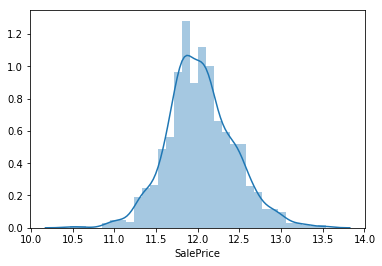

In [30]:
sns.distplot(np.log1p(y))

And our log transformed independent continuous variables.

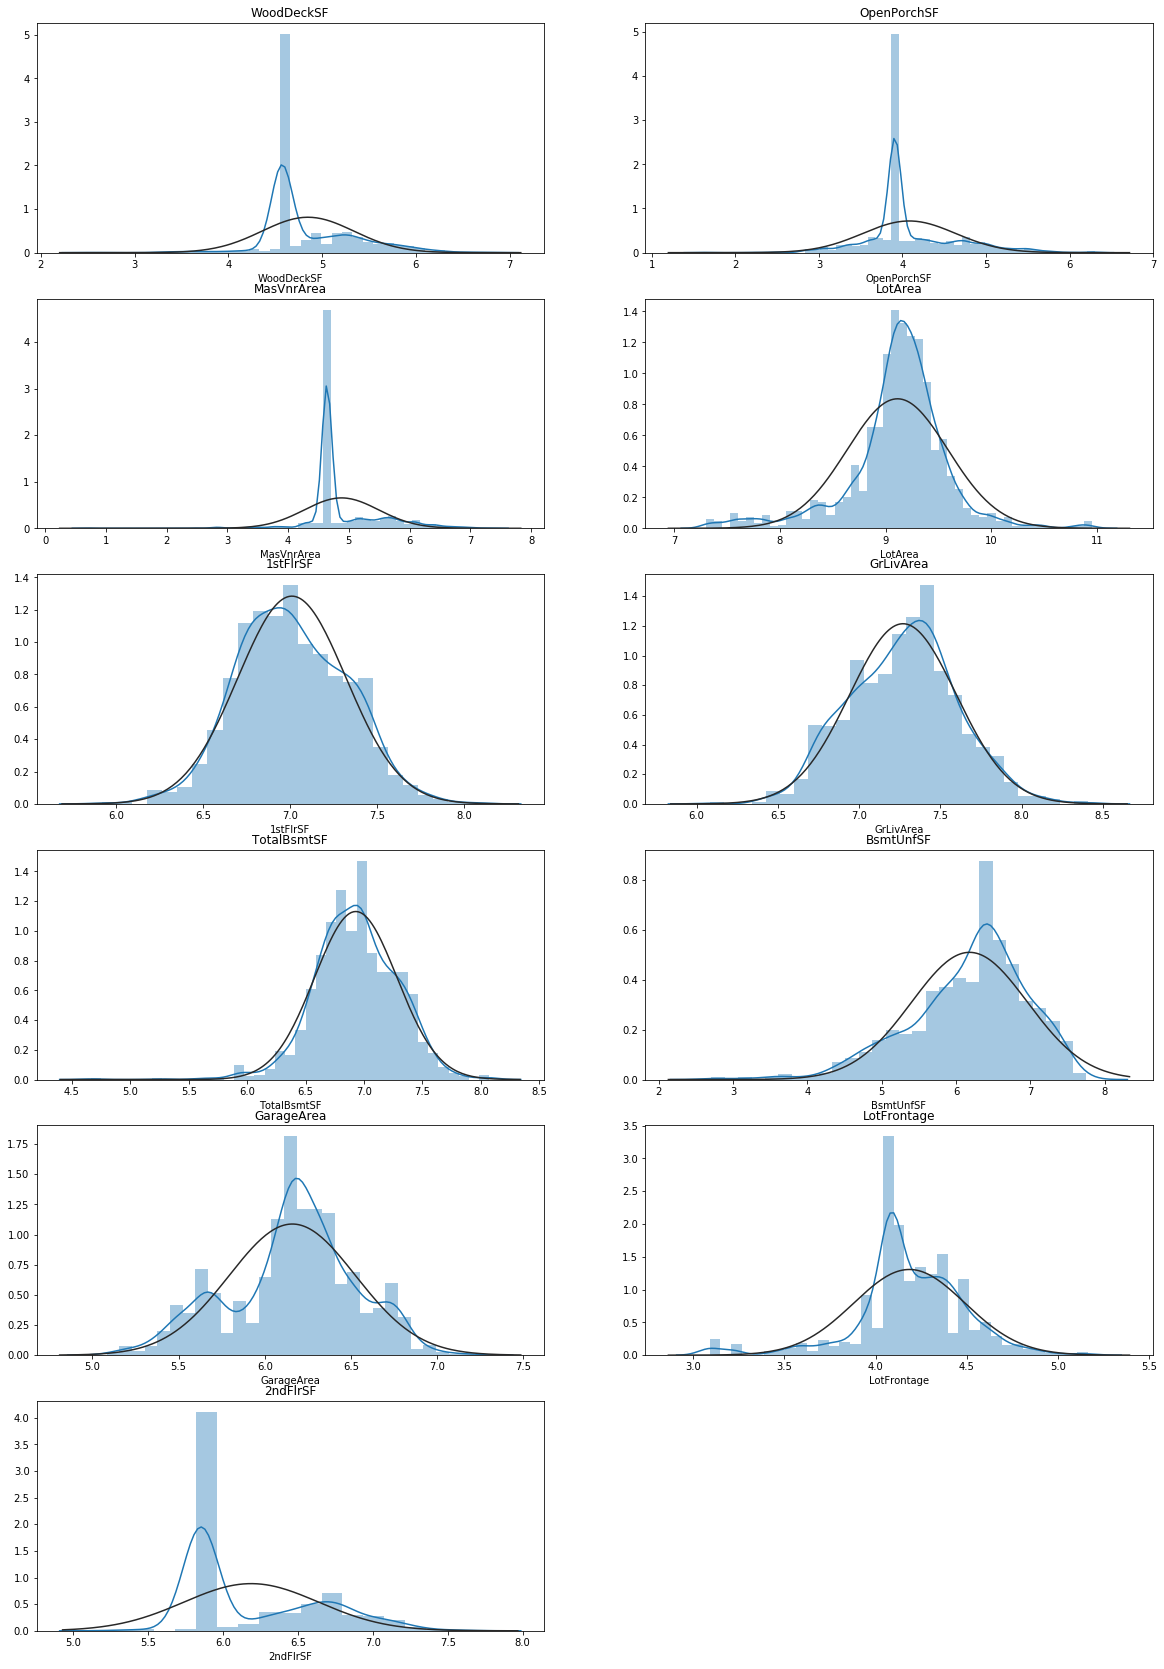

In [31]:
plt.figure(figsize=(20, 8*7.5))
for i, var in enumerate(refactor_0s):
    if var != 'SalePrice':
        plt.subplot(len(refactor_0s), 2, i+1)
        plt.title(var)
        sns.distplot(X[var], fit=stats.norm)

Our curves look a bit better than before. We still have extreme peakedness in some variables, but short of deleting a whole lot of zero values and suffer that information loss, I think we should be satisfied with their accompanying binary variables.

In [32]:
class CustomScaler(TransformerMixin): 
    def __init__(self, ignore_vars):
        self.scaler = RobustScaler()
        self.ignore_vars = ignore_vars

    def fit(self, X, y=None):
        self.scale_vars = X.drop(self.ignore_vars, axis=1).columns
        self.scaler.fit(X[self.scale_vars], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.scale_vars]), columns=self.scale_vars, index=X.index)
        X_not_scaled = X[self.ignore_vars]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

Now it remains to standard scale our datasets to a usable scale. This subtracts a variable's mean from its observations and divides them by their standard deviation.

In [33]:
continuous_feats.remove('SalePrice')
X_scaled = CustomScaler(list(set(X.columns).difference(set(continuous_feats)))).fit_transform(X)
X_hold_scaled = CustomScaler(list(set(X_holdout.columns).difference(set(continuous_feats)))).fit_transform(X_holdout)

# Ridge

In [34]:
ridge = RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50], store_cv_values=True, scoring='neg_mean_squared_error').fit(X_scaled, np.log1p(y))
print('Ridge')
print('\nCV-determined best alpha: {0}'.format(ridge.alpha_))
print('CV training MSE: {0}'.format(np.sqrt(-cross_val_score(ridge, X_scaled, np.log1p(y), scoring='neg_mean_squared_error', cv=5)).mean()))
print('\nTesting MSE: {0}'.format(np.sqrt(mean_squared_error(np.log1p(y_holdout), ridge.predict(X_hold_scaled)))))

Ridge

CV-determined best alpha: 25.0
CV training MSE: 0.11844048132370874

Testing MSE: 0.12502509656231905


### Ridge mean-squared error on testing set: 0.125

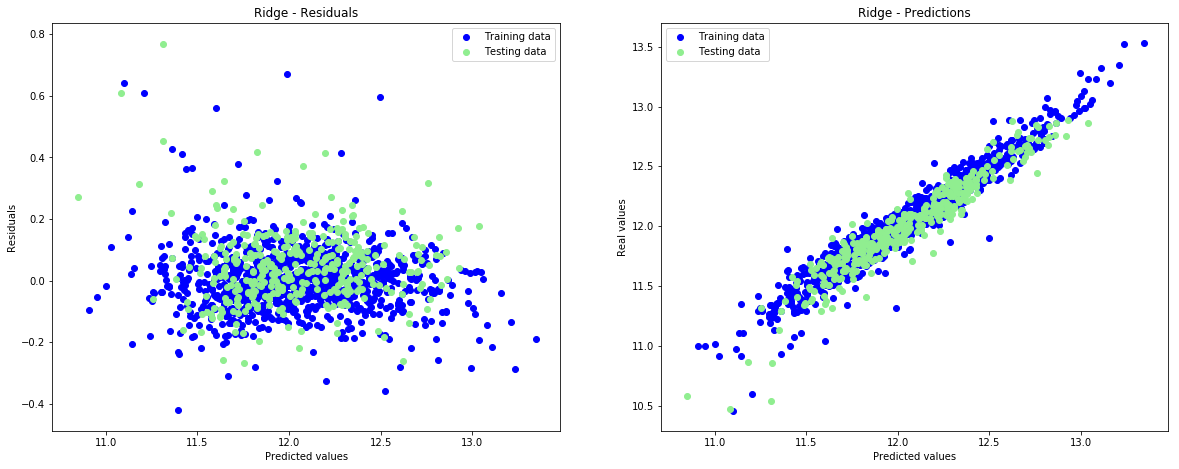

In [35]:
y_train_pred = ridge.predict(X_scaled)
y_test_pred = ridge.predict(X_hold_scaled)
plt.figure(figsize=(20, 7.5))
  
# Plot residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, y_train_pred - np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, y_test_pred - np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Ridge - Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Ridge - Predictions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend()
plt.show()  

We seem to be capturing the general trends fairly closely. I get the sense that more data would have been very helpful in this case.

# LASSO

In [36]:
lasso = LassoCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 30, 40, 50]).fit(X_scaled, np.log1p(y))
print('Lasso')
print('\nCV-determined best alpha: {0}\n'.format(lasso.alpha_))
print('CV training MSE: {0}'.format(np.sqrt(-cross_val_score(lasso, X_scaled, np.log1p(y), scoring='neg_mean_squared_error', cv=5)).mean()))
print('Testing MSE: {0}'.format(np.sqrt(mean_squared_error(np.log1p(y_holdout), lasso.predict(X_hold_scaled)))))

Lasso

CV-determined best alpha: 0.001

CV training MSE: 0.12071802062023906
Testing MSE: 0.12310307875262923


### LASSO mean-squared error on testing set: 0.1231
LASSO has outperformed ridge regression. I expect that LASSO's variable selection played a key role. We can visual all of our non-zero variables and their coefficients for comparison.

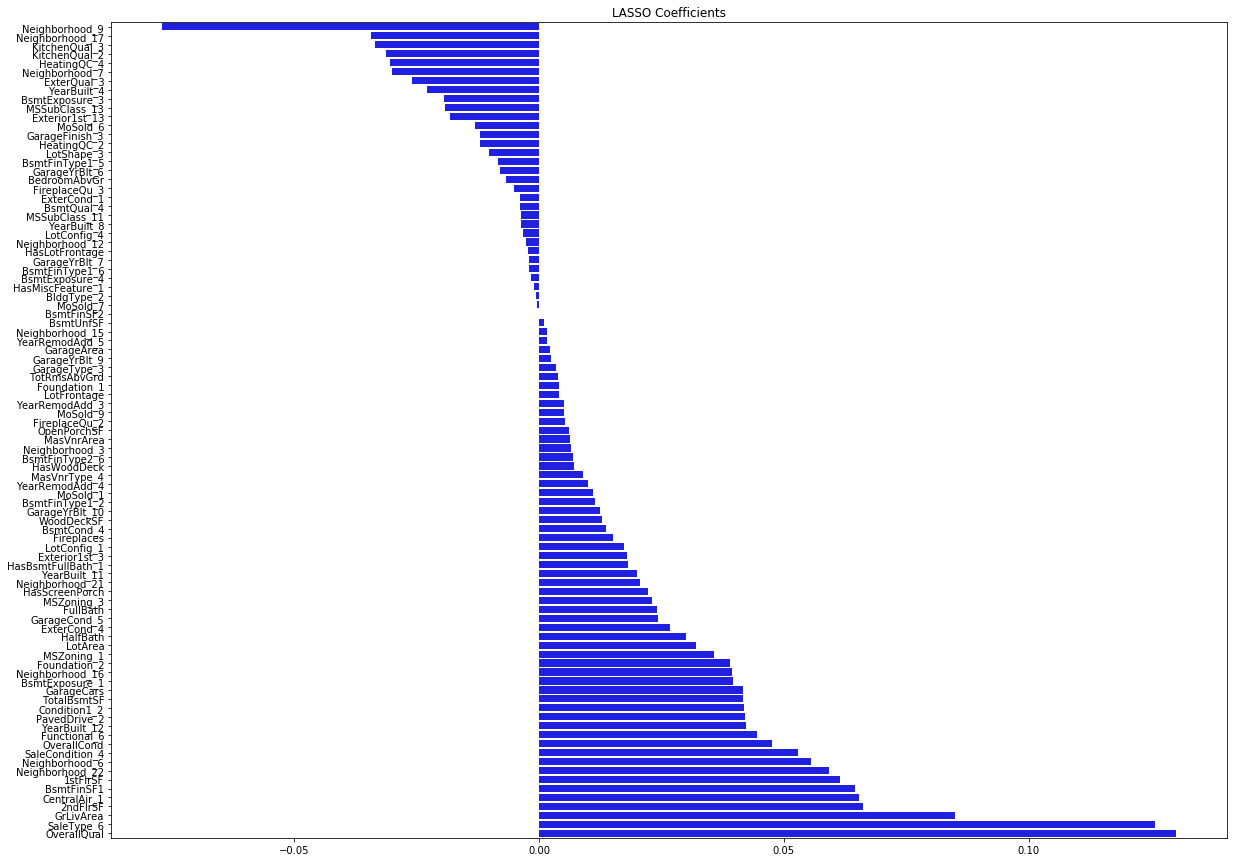

In [37]:
lasso_coef = pd.Series(lasso.coef_, index=X_scaled.columns).sort_values()
plt.figure(figsize=(20, 15))
plt.title('LASSO Coefficients')
sns.barplot(x=lasso_coef[lasso_coef != 0], y=lasso_coef[lasso_coef != 0].index, color='b')

In [38]:
pd.Series(lasso_coef[lasso_coef == 0])

MasVnrType_1      -0.0
GarageQual_4      -0.0
Exterior2nd_11    -0.0
GarageQual_5       0.0
Exterior2nd_12     0.0
Exterior2nd_13     0.0
ExterCond_3       -0.0
ExterCond_2       -0.0
ExterQual_2       -0.0
Exterior2nd_14     0.0
Exterior2nd_15    -0.0
ExterQual_1       -0.0
GarageCond_1      -0.0
MasVnrType_3       0.0
MasVnrType_2      -0.0
Exterior1st_9     -0.0
Exterior2nd_5      0.0
Exterior2nd_9     -0.0
RoofStyle_5        0.0
RoofMatl_2         0.0
RoofMatl_3         0.0
RoofMatl_4        -0.0
RoofMatl_5        -0.0
RoofMatl_6         0.0
RoofMatl_7         0.0
Exterior1st_1     -0.0
Exterior1st_2     -0.0
GarageCond_2       0.0
Exterior1st_4     -0.0
Exterior1st_5      0.0
                  ... 
GarageCond_3      -0.0
YearRemodAdd_6     0.0
BldgType_1        -0.0
Condition2_7       0.0
BldgType_4         0.0
Condition2_4       0.0
Neighborhood_10   -0.0
Neighborhood_11   -0.0
Neighborhood_13    0.0
Neighborhood_14   -0.0
MoSold_2          -0.0
Neighborhood_18   -0.0
Neighborhoo

As we can see, a huge chunk of our variables, particularly categorical variables, didn't prove themselves useful.

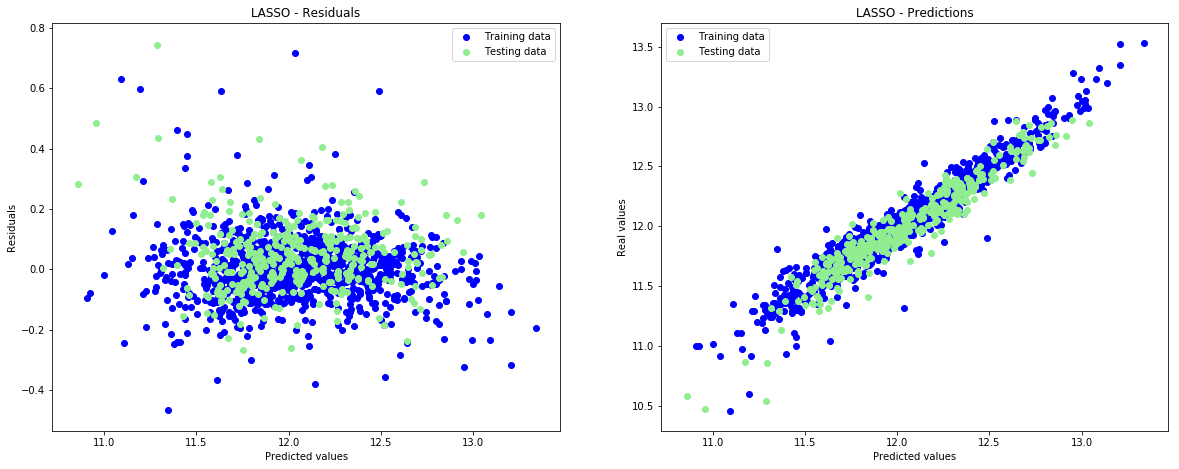

In [39]:
y_train_pred = lasso.predict(X_scaled)
y_test_pred = lasso.predict(X_hold_scaled)
plt.figure(figsize=(20, 7.5))
  
# Plot residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, y_train_pred - np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, y_test_pred - np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('LASSO - Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('LASSO - Predictions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend()
plt.show()  

# Elastic Net

In [40]:
elastic_net = ElasticNetCV(l1_ratio=[0.01, 0.05, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], alphas=np.arange(0.001, 1.0, 0.0499), random_state=10).fit(X_scaled, np.log1p(y))
print('Elastic Net')
print('\nCV-determined best alpha: {0}'.format(elastic_net.alpha_))
print('CV-determined best l1 ratio: {0}\n'.format(elastic_net.l1_ratio_))
print('CV training MSE: {0}'.format(np.sqrt(-cross_val_score(elastic_net, X_scaled, np.log1p(y), scoring='neg_mean_squared_error', cv=5)).mean()))
print('Testing MSE: {0}'.format(np.sqrt(mean_squared_error(np.log1p(y_holdout), elastic_net.predict(X_hold_scaled)))))

Elastic Net

CV-determined best alpha: 0.001
CV-determined best l1 ratio: 0.7

CV training MSE: 0.12044232495337512
Testing MSE: 0.12295926811871269


### Elastic Net mean-squared error on testing set: 0.12296
Elastic Net indeed gives you the strengths of both models.

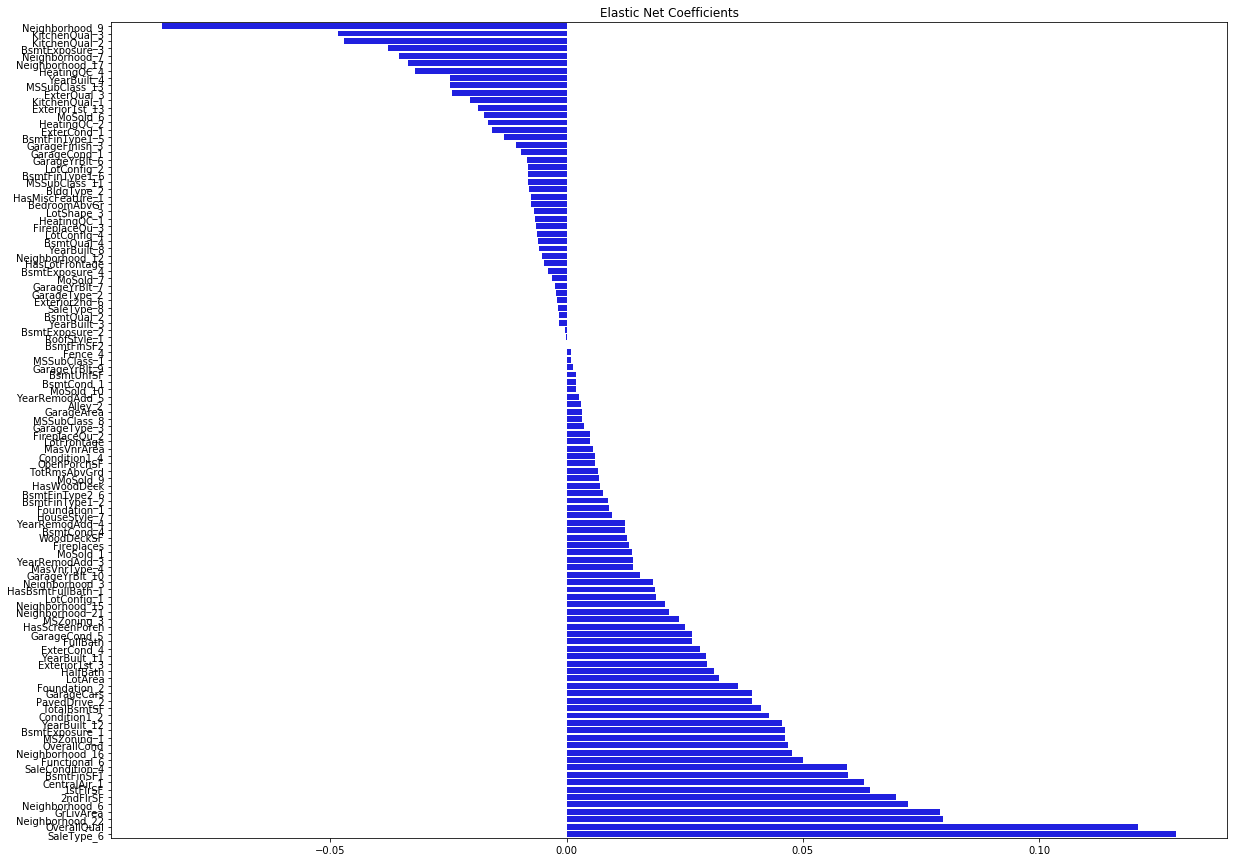

In [41]:
en_coef = pd.Series(elastic_net.coef_, index=X_scaled.columns).sort_values()
plt.figure(figsize=(20, 15))
plt.title('Elastic Net Coefficients')
sns.barplot(x=en_coef[en_coef != 0], y=en_coef[en_coef != 0].index, color='b')

In [42]:
pd.Series(en_coef[en_coef == 0])

Exterior1st_1     -0.0
Exterior2nd_4     -0.0
Exterior2nd_5     -0.0
RoofMatl_3         0.0
RoofMatl_2         0.0
Exterior2nd_7      0.0
Exterior2nd_8      0.0
Exterior2nd_9     -0.0
Exterior2nd_10    -0.0
Exterior2nd_3     -0.0
RoofStyle_5        0.0
RoofStyle_4        0.0
RoofStyle_3        0.0
Exterior2nd_12     0.0
Exterior2nd_13     0.0
Exterior2nd_14     0.0
Exterior2nd_15    -0.0
MasVnrType_1      -0.0
MasVnrType_2      -0.0
Exterior2nd_11    -0.0
RoofMatl_7         0.0
Exterior2nd_2     -0.0
GarageYrBlt_1     -0.0
RoofMatl_6         0.0
Exterior1st_2     -0.0
GarageQual_3      -0.0
GarageYrBlt_3      0.0
RoofMatl_5        -0.0
Exterior1st_4     -0.0
Exterior1st_5      0.0
                  ... 
YearRemodAdd_2    -0.0
GarageQual_5      -0.0
GarageQual_4      -0.0
YearBuilt_5        0.0
Condition2_6      -0.0
Condition2_7       0.0
Condition2_3       0.0
Neighborhood_10   -0.0
Neighborhood_11   -0.0
Neighborhood_13    0.0
Neighborhood_14   -0.0
Fence_3           -0.0
Neighborhoo

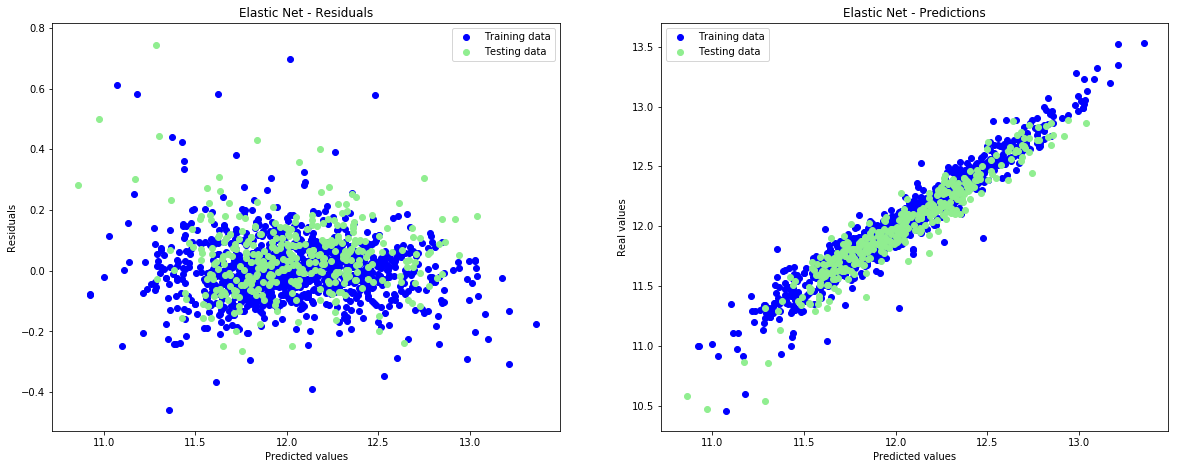

In [43]:
y_train_pred = elastic_net.predict(X_scaled)
y_test_pred = elastic_net.predict(X_hold_scaled)
plt.figure(figsize=(20, 7.5))
  
# Plot residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, y_train_pred - np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, y_test_pred - np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Elastic Net - Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Elastic Net - Predictions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend()
plt.show()   

# Conclusions
* Froms start to finish this was the fastest I've ever completed a project. I'm very glad I was able to get this additional experience using regression sooner rather than later.
* Data preparation and transformation was a headache. In later projects I would like to play around with other regression models, such as tree-based algorithms, that don't require the same kind of transformations that these models required.
* I hope to complete at least one more project before graduation in May. There are so many subjects I want to take on, such text mining and clustering. 
* In the spirit of broadening horizons, my next project will be a practice in R, rather than Python. Working with a new language will slow me down considerably, but I'm encouraged by the excitement of teaching myself a new language, just as I felt for the first time in summer of 2016, getting my feet wet with Ruby before diving headlong into my beloved Python.